# Task 11 Предсказание победителя в компьютерной игре

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

In [35]:
data_train = pd.read_csv("11/train.csv")
data_test = pd.read_csv("11/test.csv")

In [36]:
data_train.head()

,mapName,roundNum,ctScore,tScore,ctTeam,tTeam,ctFreezeTimeEndEqVal,ctRoundStartEqVal,ctBuyType,tFreezeTimeEndEqVal,tRoundStartEqVal,tBuyType,winnerSide
0,de_inferno,10,4,5,Astralis W,NIP,8400,5450,Semi Eco,27750,16150,Full Buy,0
1,de_anubis,5,2,2,Strife,Mach 5,1600,1000,Full Eco,23450,9700,Full Buy,0
2,de_inferno,11,2,8,Furious,W7M Academy,28750,17450,Full Buy,27050,6750,Full Buy,1
3,de_nuke,36,18,17,BIG,paiN,33150,12850,Full Buy,27450,9000,Full Buy,0
4,de_ancient,17,8,8,Nixuh,DNMK,10500,2350,Semi Buy,20400,1000,Full Buy,1


In [37]:
# Группировка данных по карте и стороне победителя
wins_by_map = data_train.groupby(['mapName', 'winnerSide']).size().unstack(fill_value=0)
# Переименуем столбцы для удобства
wins_by_map.columns = ['T Wins', 'CT Wins']

Пропуски:
mapName                 0
roundNum                0
ctScore                 0
tScore                  0
ctTeam                  0
tTeam                   0
ctFreezeTimeEndEqVal    0
ctRoundStartEqVal       0
ctBuyType               0
tFreezeTimeEndEqVal     0
tRoundStartEqVal        0
tBuyType                0
winnerSide              0
dtype: int64


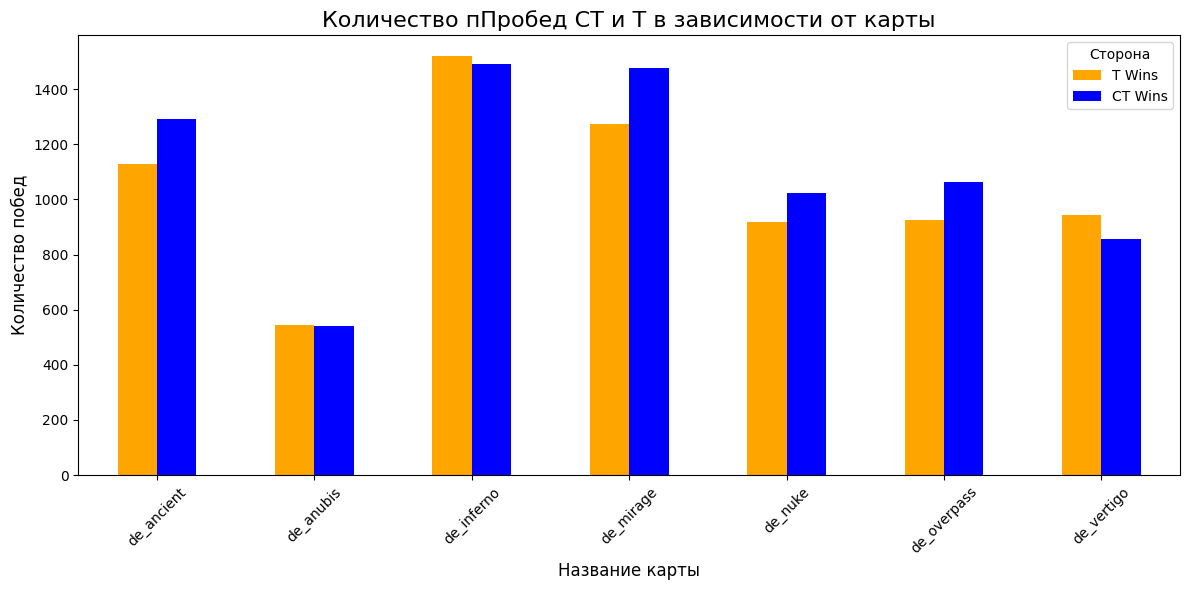

In [38]:
# Проверка на пропуски
print(f"Пропуски:\n{data_train.isnull().sum()}")

# Построение диаграммы
wins_by_map.plot(kind='bar', figsize=(12, 6), color=['orange', 'blue'])

# Настройки графика
plt.title('Количество пПробед CT и T в зависимости от карты', fontsize=16)
plt.xlabel('Название карты', fontsize=12)
plt.ylabel('Количество побед', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Сторона')
plt.tight_layout()

# Показать диаграмму
plt.show()

In [39]:
data_train.head()

,mapName,roundNum,ctScore,tScore,ctTeam,tTeam,ctFreezeTimeEndEqVal,ctRoundStartEqVal,ctBuyType,tFreezeTimeEndEqVal,tRoundStartEqVal,tBuyType,winnerSide
0,de_inferno,10,4,5,Astralis W,NIP,8400,5450,Semi Eco,27750,16150,Full Buy,0
1,de_anubis,5,2,2,Strife,Mach 5,1600,1000,Full Eco,23450,9700,Full Buy,0
2,de_inferno,11,2,8,Furious,W7M Academy,28750,17450,Full Buy,27050,6750,Full Buy,1
3,de_nuke,36,18,17,BIG,paiN,33150,12850,Full Buy,27450,9000,Full Buy,0
4,de_ancient,17,8,8,Nixuh,DNMK,10500,2350,Semi Buy,20400,1000,Full Buy,1


In [40]:
# Уникальные значения категориальных переменных
unique_ctTeam = data_train["ctTeam"].nunique()
unique_tTeam = data_train["tTeam"].nunique()
unique_ctTeam, unique_tTeam

(174, 178)

## Частотное кодирование категориальных признаков

In [41]:
# Создание функции для частотного кодирования
def frequency_encoding(column, data_train, data_test):
    freq_table = data_train[column].value_counts(normalize=True)
    data_train[column] = data_train[column].map(freq_table)
    data_test[column] = data_test[column].map(freq_table).fillna(0)  # Если категория отсутствует в тесте, заменяем 0
    return data_train, data_test

# Категориальные признаки для кодировки
categorical_columns = ['mapName', 'ctTeam', 'tTeam', 'ctBuyType', 'tBuyType']

# Применение частотного кодирования
for col in categorical_columns:
    data_train, data_test = frequency_encoding(col, data_train, data_test)

# Разделение тренировочных данных на X (признаки) и y (целевая переменная)
X = data_train.drop(columns=['winnerSide'])
y = data_train['winnerSide']

# Разделение на тренировочную и валидационную выборки
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Проверим размеры выборок
X_train.shape, X_val.shape, y_train.shape, y_val.shape, data_test.shape


((11996, 12), (3000, 12), (11996,), (3000,), (3750, 12))

In [42]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## OneHot Encoding категориальных признаков

In [43]:
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=[
    ('cat', encoder, categorical_columns)
],
remainder='passthrough',
force_int_remainder_cols=False
)

## Создание пайплайна и предсказание

In [44]:
# Строим пайплайн с предобработкой и моделью
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Обучение модели
model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['mapName', 'ctTeam', 'tTeam',
                                                   'ctBuyType',
                                                   'tBuyType'])])),
                ('classifier', RandomForestClassifier(random_state=42))])

In [45]:
y_pred_val = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred_val)
print("Accuracy:", accuracy)

Accuracy: 0.8706666666666667


In [46]:
# 8. Прогноз для тестового набора
test_predictions = model.predict(data_test)

# 9. Сохранение результатов
submission = pd.DataFrame({'winnerSide': test_predictions})
submission.to_csv('11/SampleSubmission.csv', index=False)